In [ ]:
import zipfile
import os
zip_file_path = '/content/fruitdataset.zip'
extra_dir = '/content/sample_data/extract_file'
os.makedirs(extra_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extra_dir)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

In [ ]:
print('available devices: ', tf.config.list_physical_devices())
print('tensorflow version: ', tf.__version__)

available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tensorflow version:  2.18.0


In [ ]:
base_dir = r'/content/sample_data/extract_file/fruitdataset'
train_dir = pathlib.Path(os.path.join(base_dir, 'train'))
test_dir = pathlib.Path(os.path.join(base_dir, 'test'))


In [ ]:
from importlib.resources import files
train_image_count = sum(len(files) for _, _, files in os.walk(train_dir))
test_image_count = sum(len(files) for _, _, files in os.walk(test_dir))
classes = sorted(f for f in os.listdir(train_dir) if not f.startswith('.'))
print(f'train images: {train_image_count} test images: {test_image_count} classes: {len(classes)}')

train images: 67692 test images: 22688 classes: 131


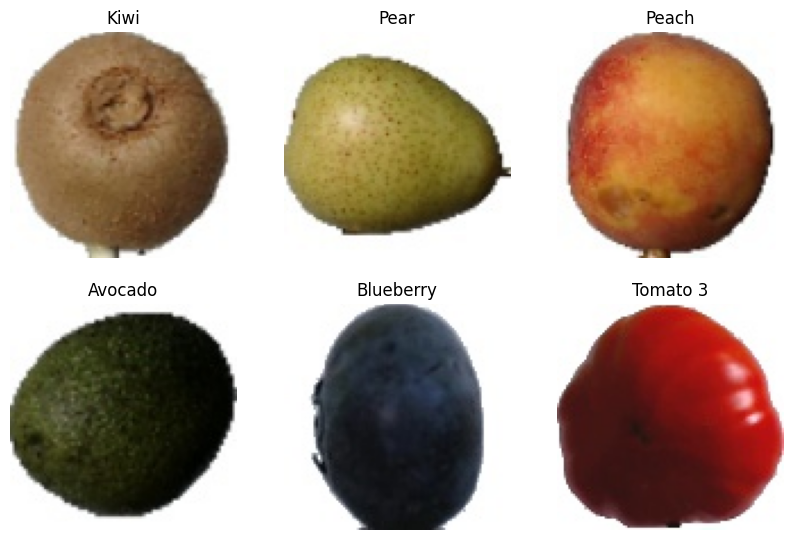

In [ ]:
fruit6 = ['Kiwi','Pear','Peach', 'Avocado', 'Blueberry','Tomato 3']
plt.figure(figsize=(10,10))
for i,fruit in enumerate(fruit6):
    img_path = list(train_dir.glob(fruit + '/*'))[0]
    plt.subplot(3,3,i+1)
    plt.imshow(Image.open(img_path))
    plt.title(fruit)
    plt.axis('off')
plt.show()

In [ ]:
def load_fruits360(path):
  data = load_files(path)
  return np.array(data['filenames']), np.array(data['target']), np.array(data['target_names'])


In [ ]:
x_train, y_train, target_labels = load_fruits360(train_dir)
x_test, y_test, _ = load_fruits360(test_dir)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [ ]:
def load_image(file_path):
  return np.array([np.array(Image.open(file))for file in file_path])

In [ ]:
x_train = load_image(x_train)
x_valid = load_image(x_valid)
x_test = load_image(x_test)

img_height, img_width = 100,100
num_classes = len(target_labels)

In [ ]:
data_aug = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical', input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model = keras.Sequential([
    data_aug,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131)            │        16,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,220,259 (4.65 MB)

 Trainable params: 1,220,259 (4.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_valid,y_valid), batch_size=32, epochs=10)

Epoch 1/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.4006 - loss: 2.3534 - val_accuracy: 0.8777 - val_loss: 0.3461
Epoch 2/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.8875 - loss: 0.3372 - val_accuracy: 0.9518 - val_loss: 0.1398
Epoch 3/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9303 - loss: 0.2069 - val_accuracy: 0.9364 - val_loss: 0.1938
Epoch 4/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9547 - loss: 0.1333 - val_accuracy: 0.9529 - val_loss: 0.1331
Epoch 5/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9607 - loss: 0.1188 - val_accuracy: 0.9381 - val_loss: 0.2008
Epoch 6/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9650 - loss: 0.1094 - val_accuracy: 0.9806 - val_loss: 0.0541
Epoch 7/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9684 - loss: 0.0962 - val_accuracy: 0.9638 - val_loss: 0.1213
Epoch 8/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9731 -

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print(f'accuracy is : {acc:.2f}')

709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8901 - loss: 0.4853
accuracy is : 0.89


In [ ]:
model.save('cnn-fruit-model.h5')

In [ ]:
img = tf.keras.preprocessing.image.load_img(r"/content/sample_data/extract_file/fruitdataset/train/Kiwi/109_100.jpg", target_size=(100, 100))
img_array = tf.expand_dims(tf.keras.utils.img_to_array(img), 0)
pred = model.predict(img_array)
score = tf.nn.softmax(pred[0])
print(f"Prediction: {target_labels[np.argmax(score)]} ({100 * np.max(score):.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Prediction: Kiwi (100.00%)
